# CMS Open Data $t\bar{t}$: from data delivery to statistical inference

This version uses the nanoAODs produced from 2015 CMS Open Data.

We are using [2015 CMS Open Data](https://cms.cern/news/first-cms-open-data-lhc-run-2-released) in this demonstration to showcase an analysis pipeline.
It features data delivery and processing, histogram construction and visualization, as well as statistical inference.

This notebook was developed in the context of the [IRIS-HEP AGC tools 2022 workshop](https://indico.cern.ch/e/agc-tools-2).
This work was supported by the U.S. National Science Foundation (NSF) Cooperative Agreement OAC-1836650 (IRIS-HEP).

This is a **technical demonstration**.
We are including the relevant workflow aspects that physicists need in their work, but we are not focusing on making every piece of the demonstration physically meaningful.
This concerns in particular systematic uncertainties: we capture the workflow, but the actual implementations are more complex in practice.
If you are interested in the physics side of analyzing top pair production, check out the latest results from [ATLAS](https://twiki.cern.ch/twiki/bin/view/AtlasPublic/TopPublicResults) and [CMS](https://cms-results.web.cern.ch/cms-results/public-results/preliminary-results/)!
If you would like to see more technical demonstrations, also check out an [ATLAS Open Data example](https://indico.cern.ch/event/1076231/contributions/4560405/) demonstrated previously.

This notebook implements most of the analysis pipeline shown in the following picture, using the tools also mentioned there:
![ecosystem visualization](utils/ecosystem.png)

### Data pipelines

To be a bit more precise, we are going to be looking at three different data pipelines:
![processing pipelines](utils/processing_pipelines.png)

### Imports: setting up our environment

In [1]:
import asyncio
import logging
import os
import time

os.environ['OPENBLAS_NUM_THREADS'] = '1'

import vector; vector.register_awkward()

import awkward as ak
import cabinetry
from coffea import processor
from coffea.processor import servicex
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import NanoAODSchema
from func_adl import ObjectStream
import hist
import json
import matplotlib.pyplot as plt
import numpy as np
import uproot

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

import xgboost as xgb

logging.getLogger("cabinetry").setLevel(logging.INFO)

### Configuration: number of files and data delivery path

The number of files per sample set here determines the size of the dataset we are processing.
There are 12 samples being used here, all part of the 2015 CMS Open Data release.
They are converted from miniAOD files into nanoAOD format.
More details about the inputs can be found [here](https://github.com/iris-hep/analysis-grand-challenge/tree/main/datasets/cms-open-data-2015).

The table below summarizes the amount of data processed depending on the `N_FILES_MAX_PER_SAMPLE` setting.

| setting | number of files | total size |
| --- | --- | --- |
| `1` | 12 | 25.1 GB |
| `2` | 24 | 46.5 GB |
| `5` | 52 | 110 GB |
| `10` | 88 | 205 GB |
| `20` | 149 | 364 GB |
| `50` | 264 | 636 GB |
| `100` | 404 | 965 GB |
| `200` | 604 | 1.40 TB |
| `-1` | 796 | 1.78 TB |

The input files are all in the 1–3 GB range.

When setting the `PIPELINE` variable below to `"servicex_databinder"`, the `N_FILES_MAX_PER_SAMPLE` variable is ignored and all files are processed.

In [12]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 30

# pipeline to use:
# - "coffea" for pure coffea setup
# - "servicex_processor" for coffea with ServiceX processor
# - "servicex_databinder" for downloading query output and subsequent standalone coffea
PIPELINE = "coffea"

# enable Dask (may not work yet in combination with ServiceX outside of coffea-casa)
USE_DASK = True

# ServiceX behavior: ignore cache with repeated queries
SERVICEX_IGNORE_CACHE = False

# analysis facility: set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups
AF = "coffea_casa"

### BENCHMARKING-SPECIFIC SETTINGS

# chunk size to use
CHUNKSIZE = 50_000

# metadata to propagate through to metrics
AF_NAME = "coffea_casa"  # "ssl-dev" allows for the switch to local data on /data
SYSTEMATICS = "all"  # currently has no effect
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

# scaling for local setups with FuturesExecutor
NUM_CORES = 1

# only I/O, all other processing disabled
DISABLE_PROCESSING = False

# read additional branches (only with DISABLE_PROCESSING = True)
# acceptable values are 2.7, 4, 15, 25, 50 (corresponding to % of file read), 2.7% corresponds to the standard branches used in the notebook
IO_FILE_PERCENT = 2.7

# ML options
MAX_N_JETS = 6 # maximum number of jets to consider in reconstruction BDT

MODEL = "models/model_allcombinations_xgb.json" # BDT json

In [13]:
permutations_dict = {}
for n in range(4,MAX_N_JETS+1):
    test = ak.Array(range(n))
    unzipped = ak.unzip(ak.argcartesian([test]*4,axis=0))

    combos = ak.combinations(ak.Array(range(4)), 2, axis=0)
    different = unzipped[combos[0]["0"]]!=unzipped[combos[0]["1"]]
    for i in range(1,len(combos)):
        different = different & (unzipped[combos[i]["0"]]!=unzipped[combos[i]["1"]])

    permutations = ak.zip([test[unzipped[i][different]] for i in range(len(unzipped))],
                          depth_limit=1).tolist()


    permutations = ak.concatenate([test[unzipped[i][different]][..., np.newaxis] 
                                   for i in range(len(unzipped))], 
                                  axis=1).to_list()

    print("number of permutations for n=",n,": ", len(permutations))
    
    permutations_dict[n] = permutations

number of permutations for n= 4 :  24
number of permutations for n= 5 :  120
number of permutations for n= 6 :  360


In [14]:
## get inputs to BDT
def get_features(jets, electrons, muons, permutations_dict):
    '''
    Calculate features for each of the 12 combinations per event
    
    Args:
        jets: selected jets
        electrons: selected electrons
        muons: selected muons
        permutations_dict: which permutations to consider for each number of jets in an event
    
    Returns:
        features (flattened to remove event level)
    '''
    
    # calculate number of jets in each event
    njet = ak.num(jets).to_numpy()
    # don't consider every jet for events with high jet multiplicity
    njet[njet>max(permutations_dict.keys())] = max(permutations_dict.keys())
    # create awkward array of permutation indices
    perms = ak.Array([permutations_dict[n] for n in njet])
    
    
    #### calculate features ####
    
    # grab lepton info
    lepton_eta = (ak.sum(electrons.eta,axis=-1) + ak.sum(muons.eta,axis=-1))
    lepton_phi = (ak.sum(electrons.phi,axis=-1) + ak.sum(muons.phi,axis=-1))
    lepton_mass = (ak.sum(electrons.mass,axis=-1) + ak.sum(muons.mass,axis=-1))

    # delta R between top1 and lepton
    deltar_0 = np.sqrt((lepton_eta - jets[perms[...,3]].eta)**2 + 
                       (lepton_phi - jets[perms[...,3]].phi)**2)

    # delta R between the two W
    deltar_1 = np.sqrt((jets[perms[...,0]].eta - jets[perms[...,1]].eta)**2 + 
                       (jets[perms[...,0]].phi - jets[perms[...,1]].phi)**2)

    # delta R between W and top2
    deltar_2 = np.sqrt((jets[perms[...,0]].eta - jets[perms[...,2]].eta)**2 + 
                       (jets[perms[...,0]].phi - jets[perms[...,2]].phi)**2)
    deltar_3 = np.sqrt((jets[perms[...,1]].eta - jets[perms[...,2]].eta)**2 + 
                       (jets[perms[...,1]].phi - jets[perms[...,2]].phi)**2)

    # delta phi between top1 and lepton
    deltaphi_0 = np.abs(lepton_phi - jets[perms[...,3]].phi)

    # delta phi between the two W
    deltaphi_1 = np.abs(jets[perms[...,0]].phi - jets[perms[...,1]].phi)

    # delta phi between W and top2
    deltaphi_2 = np.abs(jets[perms[...,0]].phi - jets[perms[...,2]].phi)
    deltaphi_3 = np.abs(jets[perms[...,1]].phi - jets[perms[...,2]].phi)

    # combined mass of top1 and lepton
    combinedmass_0 = lepton_mass + jets[perms[...,3]].mass

    # combined mass of W
    combinedmass_1 = jets[perms[...,0]].mass + jets[perms[...,1]].mass

    # combined mass of W and top2
    combinedmass_2 = jets[perms[...,0]].mass + jets[perms[...,1]].mass + jets[perms[...,2]].mass

    # # pt of every jet
    jetpt_0 = jets[perms[...,0]].pt
    jetpt_1 = jets[perms[...,1]].pt
    jetpt_2 = jets[perms[...,2]].pt
    jetpt_3 = jets[perms[...,3]].pt

    # # mass of every jet
    jetmass_0 = jets[perms[...,0]].mass
    jetmass_1 = jets[perms[...,1]].mass
    jetmass_2 = jets[perms[...,2]].mass
    jetmass_3 = jets[perms[...,3]].mass

    features = ak.concatenate([deltar_0[..., np.newaxis],
                               deltar_1[..., np.newaxis],
                               deltar_2[..., np.newaxis],
                               deltar_3[..., np.newaxis],
                               deltaphi_0[..., np.newaxis],
                               deltaphi_1[..., np.newaxis],
                               deltaphi_2[..., np.newaxis],
                               deltaphi_3[..., np.newaxis],
                               combinedmass_0[..., np.newaxis],
                               combinedmass_1[..., np.newaxis],
                               combinedmass_2[..., np.newaxis],
                               jetpt_0[..., np.newaxis],
                               jetpt_1[..., np.newaxis],
                               jetpt_2[..., np.newaxis],
                               jetpt_3[..., np.newaxis],
                               jetmass_0[..., np.newaxis],
                               jetmass_1[..., np.newaxis],
                               jetmass_2[..., np.newaxis],
                               jetmass_3[..., np.newaxis]], 
                              axis=2)

    # keep counts to unflatten
    perm_counts = ak.num(features)
    # flatten features
    features = ak.flatten(features, axis=1)    
        
    return features, perm_counts

### Defining our `coffea` Processor

The processor includes a lot of the physics analysis details:
- event filtering and the calculation of observables,
- event weighting,
- calculating systematic uncertainties at the event and object level,
- filling all the information into histograms that get aggregated and ultimately returned to us by `coffea`.

In [15]:
processor_base = processor.ProcessorABC if (PIPELINE != "servicex_processor") else servicex.Analysis

# functions creating systematic variations
def flat_variation(ones):
    # 2.5% weight variations
    return (1.0 + np.array([0.025, -0.025], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (7.5% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.075, -0.075]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


class TtbarAnalysis(processor_base):
    def __init__(self, disable_processing, io_file_percent, permutations_dict, model):#, model_name):
        num_bins = 25
        bin_low = 50
        bin_high = 550
        name = "observable"
        label = "observable [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .Reg(num_bins, 0, 2*np.pi, overflow=False, underflow=False, 
                 name="deltaR", label="$\Delta R$ between two W jets")
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )
        self.disable_processing = disable_processing
        self.io_file_percent = io_file_percent
        self.permutations_dict = permutations_dict
        #self.model_name = model_name # need to pass name if using FuturesExecutor
        self.model = model # need to pass model if using DaskExecutor

    def only_do_IO(self, events):
        # standard AGC branches cover 2.7% of the data
            branches_to_read = []
            if self.io_file_percent >= 2.7:
                branches_to_read.extend(["Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagCSVV2", "Jet_mass", "Muon_pt", "Electron_pt"])
            
            if self.io_file_percent >= 4:
                branches_to_read.extend(["Electron_phi", "Electron_eta","Electron_mass","Muon_phi","Muon_eta","Muon_mass",
                                         "Photon_pt","Photon_eta","Photon_mass","Jet_jetId"])
            
            if self.io_file_percent>=15:
                branches_to_read.extend(["Jet_nConstituents","Jet_electronIdx1","Jet_electronIdx2","Jet_muonIdx1","Jet_muonIdx2",
                                         "Jet_chHEF","Jet_area","Jet_puId","Jet_qgl","Jet_btagDeepB","Jet_btagDeepCvB",
                                         "Jet_btagDeepCvL","Jet_btagDeepFlavB","Jet_btagDeepFlavCvB","Jet_btagDeepFlavCvL",
                                         "Jet_btagDeepFlavQG","Jet_chEmEF","Jet_chFPV0EF","Jet_muEF","Jet_muonSubtrFactor",
                                         "Jet_neEmEF","Jet_neHEF","Jet_puIdDisc"])
            
            if self.io_file_percent>=25:
                branches_to_read.extend(["Jet_rawFactor","Jet_bRegCorr","Jet_bRegRes","Jet_cRegCorr","Jet_cRegRes","Jet_nElectrons",
                                         "Jet_nMuons","GenJet_pt","GenJet_eta","GenJet_phi","GenJet_mass","Tau_pt","Tau_eta","Tau_mass",
                                         "Tau_phi","Muon_dxy","Muon_dxyErr","Muon_dxybs","Muon_dz","Muon_dzErr","Electron_dxy",
                                         "Electron_dxyErr","Electron_dz","Electron_dzErr","Electron_eInvMinusPInv","Electron_energyErr",
                                         "Electron_hoe","Electron_ip3d","Electron_jetPtRelv2","Electron_jetRelIso",
                                         "Electron_miniPFRelIso_all","Electron_miniPFRelIso_chg","Electron_mvaFall17V2Iso",
                                         "Electron_mvaFall17V2noIso","Electron_pfRelIso03_all","Electron_pfRelIso03_chg","Electron_r9",
                                         "Electron_scEtOverPt","Electron_sieie","Electron_sip3d","Electron_mvaTTH","Electron_charge",
                                         "Electron_cutBased","Electron_jetIdx","Electron_pdgId","Electron_photonIdx","Electron_tightCharge"])
            
            if self.io_file_percent==50:
                branches_to_read.extend(["GenPart_pt","GenPart_eta","GenPart_phi","GenPart_mass","GenPart_genPartIdxMother",
                                         "GenPart_pdgId","GenPart_status","GenPart_statusFlags"])
                
            if self.io_file_percent not in [2.7, 4, 15, 25, 50]:
                raise NotImplementedError("supported values for I/O percentage are 4, 15, 25, 50")
            
            for branch in branches_to_read:
                if "_" in branch:
                    split = branch.split("_")
                    object_type = split[0]
                    property_name = '_'.join(split[1:])
                    ak.materialized(events[object_type][property_name])
                else:
                    ak.materialized(events[branch])
            return {"hist": {}}

    def process(self, events):
        if self.disable_processing:
            # IO testing with no subsequent processing
            return self.only_do_IO(events)

        # only if futuresexecutor
        # model = xgb.XGBClassifier()
        # model.load_model(self.model_name)
        
        # only if daskexecutor
        model = self.model
        
        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        #### systematics
        # example of a simple flat weight variation, using the coffea nanoevents systematics feature
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)

        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.Jet.pt)

        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:

            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # pT > 25 GeV for leptons & jets
            selected_electrons = events.Electron[events.Electron.pt > 30]
            selected_muons = events.Muon[events.Muon.pt > 30]
            jet_filter = events.Jet.pt * events[pt_var] > 30  # pT > 25 GeV for jets (scaled by systematic variations)
            selected_jets = events.Jet[jet_filter]

            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # at least four jets
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            # at least one b-tagged jet ("tag" means score above threshold)
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)

            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]

            for region in ["4j1b", "4j2b"]:
                # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
                if region == "4j1b":
                    
                    region_filter = ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) == 1
                    
                    selected_jets_region = selected_jets[region_filter]
                    selected_electrons_region = selected_electrons[region_filter]
                    selected_muons_region = selected_muons[region_filter]
                    
                    # use HT (scalar sum of jet pT) as observable
                    pt_var_modifier = (
                        events[event_filters][region_filter][pt_var]
                        if "res" not in pt_var
                        else events[pt_var][jet_filter][event_filters][region_filter]
                    )
                    observable = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)
                    
                    # ML component
                    features, perm_counts = get_features(selected_jets_region, 
                                                         selected_electrons_region, 
                                                         selected_muons_region, 
                                                         self.permutations_dict)
                    BDT_results = ak.unflatten(model.predict_proba(features)[:, 1], perm_counts)
                    features_unflattened = ak.unflatten(features, perm_counts)
                    which_combination = ak.argmax(BDT_results,axis=1)
                    ML_observable = ak.flatten(features_unflattened[ak.from_regular(which_combination[:, np.newaxis])])[...,5]
                    # ML_observable = observable
                    
                elif region == "4j2b":
                    region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
                    
                    selected_jets_region = selected_jets[region_filter]
                    selected_electrons_region = selected_electrons[region_filter]
                    selected_muons_region = selected_muons[region_filter]

                    # reconstruct hadronic top as bjj system with largest pT
                    # the jet energy scale / resolution effect is not propagated to this observable at the moment
                    trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)
                    
                    # ML component
                    features, perm_counts = get_features(selected_jets_region, 
                                                         selected_electrons_region, 
                                                         selected_muons_region, 
                                                         self.permutations_dict)
                    
                    BDT_results = ak.unflatten(model.predict_proba(features)[:, 1], perm_counts)
                    features_unflattened = ak.unflatten(features, perm_counts)
                    which_combination = ak.argmax(BDT_results,axis=1)
                    ML_observable = ak.flatten(features_unflattened[ak.from_regular(which_combination[:, np.newaxis])])[...,5]
                    # ML_observable = observable

                ### histogram filling
                if pt_var == "pt_nominal":
                    # nominal pT, but including 2-point systematics
                    histogram.fill(
                            observable=observable, deltaR = ML_observable, region=region, process=process,
                            variation=variation, weight=xsec_weight
                        )

                    if variation == "nominal":
                        # also fill weight-based variations for all nominal samples
                        for weight_name in events.systematics.fields:
                            for direction in ["up", "down"]:
                                # extract the weight variations and apply all event & region filters
                                weight_variation = events.systematics[weight_name][direction][
                                    f"weight_{weight_name}"][event_filters][region_filter]
                                # fill histograms
                                histogram.fill(
                                    observable=observable, deltaR = ML_observable, region=region, process=process,
                                    variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                        # calculate additional systematics: b-tagging variations
                        for i_var, weight_name in enumerate([f"btag_var_{i}" for i in range(4)]):
                            for i_dir, direction in enumerate(["up", "down"]):
                                # create systematic variations that depend on object properties (here: jet pT)
                                if len(observable):
                                    weight_variation = btag_weight_variation(i_var, selected_jets_region.pt)[:, i_dir]
                                else:
                                    weight_variation = 1 # no events selected
                                histogram.fill(
                                    observable=observable, deltaR = ML_observable, region=region, process=process,
                                    variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                elif variation == "nominal":
                    # pT variations for nominal samples
                    histogram.fill(
                            observable=observable, deltaR = ML_observable, region=region, process=process,
                            variation=pt_var, weight=xsec_weight
                        )

        output = {"nevents": {events.metadata["dataset"]: len(events)}, 
                  "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [16]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, 
                                  use_xcache=False, 
                                  af_name=AF_NAME,
                                  json_file='ntuples_nanoaod_agc.json',
                                  startind=0)  # local files on /data for ssl-dev

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'single_top_tW__scaledown', 'single_top_tW__scaleup', 'single_top_tW__DS', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 31583411, 'xsec': 729.84}
}


In [17]:
fileset_keys = list(fileset.keys())
for key in fileset_keys:
    if not ((key=="ttbar__nominal") | 
            (key=="single_top_s_chan__nominal") | 
            (key=="single_top_t_chan__nominal") | 
            (key=="single_top_tW__nominal") | 
            (key=="wjets__nominal")
           ):
        fileset.pop(key)

In [18]:
fileset

{'ttbar__nominal': {'files': ['https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0001.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0002.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0003.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0004.

### ServiceX-specific functionality: query setup

Define the func_adl query to be used for the purpose of extracting columns and filtering.

In [19]:
def get_query(source: ObjectStream) -> ObjectStream:
    """Query for event / column selection: >=4j >=1b, ==1 lep with pT>25 GeV, return relevant columns
    """
    return source.Where(lambda e:
        # == 1 lep
        e.Electron_pt.Where(lambda pT: pT > 25).Count() + e.Muon_pt.Where(lambda pT: pT > 25).Count()== 1
        )\
        .Where(lambda e:\
            # >= 4 jets
            e.Jet_pt.Where(lambda pT: pT > 25).Count() >= 4
        )\
        .Where(lambda e:\
            # >= 1 jet with pT > 25 GeV and b-tag >= 0.5
            {"pT": e.Jet_pt, "btag": e.Jet_btagCSVV2}.Zip().Where(lambda jet: jet.btagCSVV2 >= 0.5 and jet.pT > 25).Count() >= 1
        )\
        .Select(lambda e:\
            # return columns
            {
                "electron_e": e.Electron_energy,
                "electron_pt": e.Electron_pt,
                "muon_e": e.Muon_energy,
                "muon_pt": e.Muon_pt,
                "jet_e": e.Jet_e,
                "jet_pt": e.Jet_pt,
                "jet_eta": e.Jet_eta,
                "jet_phi": e.Jet_phi,
                "jet_btag": e.Jet_btagCSVV2,
                "numbermuon": e.nMuon,
                "numberelectron": e.nElectron,
                "numberjet": e.nJet,
            }
        )

### Standalone ServiceX for subsequent `coffea` processing

Using `servicex-databinder`, we can execute a query and download the output.
As the files are currently accessible through `rucio` only with ATLAS credentials, you need to use an ATLAS ServiceX instance to run this (for example via the UChicago coffea-casa analysis facility).

In [20]:
if PIPELINE == "servicex_databinder":
    from servicex_databinder import DataBinder
    t0 = time.time()

    import inspect
 
    query_string = inspect.getsource(get_query).split("return source.")[-1]  # extract query from function defined previously
    
    sample_names = ["ttbar__nominal", "ttbar__scaledown", "ttbar__scaleup", "ttbar__ME_var", "ttbar__PS_var",
                    "single_top_s_chan__nominal", "single_top_t_chan__nominal", "single_top_tW__nominal", "wjets__nominal"]
    sample_names = ["single_top_s_chan__nominal"]  # for quick tests: small dataset with only 50 files
    sample_list = []

    for sample_name in sample_names:
        sample_list.append({"Name": sample_name, "RucioDID": f"user.ivukotic:user.ivukotic.{sample_name}", "Tree": "events", "FuncADL": query_string})


    databinder_config = {
                            "General": {
                                           "ServiceXBackendName": "uproot",
                                            "OutputDirectory": "outputs_databinder",
                                            "OutputFormat": "root",
                                            "IgnoreServiceXCache": SERVICEX_IGNORE_CACHE
                            },
                            "Sample": sample_list
                        }

    sx_db = DataBinder(databinder_config)
    # out = sx_db.deliver(timer=True)
    parquet_paths = sx_db._sx.get_servicex_data()  # only run transform, do not download as well
    print(f"execution took {time.time() - t0:.2f} seconds")
    
    # point to ROOT files from databinder
    # update list of fileset files, pointing to ServiceX output for subsequent processing
    # for process in fileset.keys():
    #     if out.get(process):
    #         fileset[process]["files"] = out[process]
    
    # point directly to parquet files from databinder
    # update paths to point to ServiceX outputs
    for sample_name, sample_paths in zip([sample['Name'] for sample in databinder_config['Sample']], parquet_paths):
        print(f"updating paths for {sample_name} with {len(sample_paths)} parquet files (e.g. {sample_paths[0]}")
        fileset[sample_name]["files"] = sample_paths

### Execute the data delivery pipeline

What happens here depends on the configuration setting for `PIPELINE`:
- when set to `servicex_processor`, ServiceX will feed columns to `coffea` processors, which will asynchronously process them and accumulate the output histograms,
- when set to `coffea`, processing will happen with pure `coffea`,
- if `PIPELINE` was set to `servicex_databinder`, the input data has already been pre-processed and will be processed further with `coffea`.

In [21]:
# if DaskExecutor
model = xgb.XGBClassifier()
model.load_model(MODEL)

if PIPELINE == "coffea":
    if USE_DASK:
        executor = processor.DaskExecutor(client=utils.get_client(AF))#, n_cores=1))
    else:
        executor = processor.FuturesExecutor(workers=NUM_CORES)

    run = processor.Runner(executor=executor, 
                           schema=NanoAODSchema, 
                           savemetrics=True, 
                           metadata_cache={}, 
                           chunksize=CHUNKSIZE)

    filemeta = run.preprocess(fileset, treename="Events")  # pre-processing

    t0 = time.monotonic()
    
    # processing
    all_histograms, metrics = run(fileset, 
                                  "Events", 
                                  processor_instance=TtbarAnalysis(DISABLE_PROCESSING, 
                                                                   IO_FILE_PERCENT,
                                                                   permutations_dict,
                                                                   model))
    exec_time = time.monotonic() - t0
    # all_histograms = all_histograms["hist"]

elif PIPELINE == "servicex_processor":
    # in a notebook:
    t0 = time.monotonic()
    all_histograms = await utils.produce_all_histograms(fileset, get_query, TtbarAnalysis(DISABLE_PROCESSING, IO_FILE_PERCENT),
                                                        use_dask=USE_DASK, ignore_cache=SERVICEX_IGNORE_CACHE, schema=AGCSchema)
    exec_time = time.monotonic() - t0

    # as a script:
    # async def produce_all_the_histograms():
    #     return await utils.produce_all_histograms(fileset, get_query, TtbarAnalysis(DISABLE_PROCESSING, IO_FILE_PERCENT),
    #                                               use_dask=USE_DASK, ignore_cache=SERVICEX_IGNORE_CACHE, schema=AGCSchema)
    #
    # all_histograms = asyncio.run(produce_all_the_histograms())

elif PIPELINE == "servicex_databinder":
    # needs a slightly different schema, not currently implemented
    raise NotImplementedError("further processing of this method is not currently implemented")

print(f"\nexecution took {exec_time:.2f} seconds")

[########################################] | 100% Completed | 34min 36.3s
execution took 2077.26 seconds


In [22]:
all_histograms

{'nevents': {'ttbar__nominal': 31583411,
  'wjets__nominal': 35226616,
  'single_top_t_chan__nominal': 35246252,
  'single_top_tW__nominal': 1999400,
  'single_top_s_chan__nominal': 2867199},
 'hist': Hist(
   Regular(25, 50, 550, name='observable', label='observable [GeV]'),
   Regular(25, 0, 6.28319, underflow=False, overflow=False, name='deltaR', label='$\\Delta R$ between two W jets'),
   StrCategory(['4j1b', '4j2b'], name='region', label='Region'),
   StrCategory(['ttbar', 'wjets', 'single_top_t_chan', 'single_top_tW', 'single_top_s_chan'], growth=True, name='process', label='Process'),
   StrCategory(['nominal', 'btag_var_0_up', 'btag_var_0_down', 'btag_var_1_up', 'btag_var_1_down', 'btag_var_2_up', 'btag_var_2_down', 'btag_var_3_up', 'btag_var_3_down', 'pt_scale_up', 'pt_res_up', 'scale_var_up', 'scale_var_down'], growth=True, name='variation', label='Systematic variation'),
   storage=Weight()) # Sum: WeightedSum(value=9.22826e+06, variance=3.62602e+06) (WeightedSum(value=1.029

In [23]:
# track metrics for pure coffea setups
if PIPELINE == "coffea":
    # update metrics
    dataset_source = "/data" if fileset["ttbar__nominal"]["files"][0].startswith("/data") else "https://xrootd-local.unl.edu:1094" # TODO: xcache support
    metrics.update({"walltime": exec_time, "num_workers": NUM_CORES, "af": AF_NAME, "dataset_source": dataset_source, "use_dask": USE_DASK,
                    "systematics": SYSTEMATICS, "n_files_max_per_sample": N_FILES_MAX_PER_SAMPLE, "pipeline": PIPELINE,
                    "cores_per_worker": CORES_PER_WORKER, "chunksize": CHUNKSIZE, "disable_processing": DISABLE_PROCESSING, "io_file_percent": IO_FILE_PERCENT})

    # save metrics to disk
    if not os.path.exists("metrics"):
        os.makedirs("metrics")
    timestamp = time.strftime('%Y%m%d-%H%M%S')
    metric_file_name = f"metrics/nanoAOD-{AF_NAME}-{timestamp}.json"
    with open(metric_file_name, "w") as f:
        f.write(json.dumps(metrics))

    print(f"metrics saved as {metric_file_name}")
    #print(f"event rate per worker (full execution time divided by NUM_CORES={NUM_CORES}): {metrics['entries'] / NUM_CORES / exec_time / 1_000:.2f} kHz")
    print(f"event rate per worker (pure processtime): {metrics['entries'] / metrics['processtime'] / 1_000:.2f} kHz")
    print(f"amount of data read: {metrics['bytesread']/1000**2:.2f} MB")  # likely buggy: https://github.com/CoffeaTeam/coffea/issues/717

metrics saved as metrics/nanoAOD-coffea_casa-20230123-140821.json
event rate per worker (pure processtime): 1.15 kHz
amount of data read: 14369.55 MB


### Inspecting the produced histograms

Let's have a look at the data we obtained.
We built histograms in two phase space regions, for multiple physics processes and systematic variations.

In [24]:
all_histograms = all_histograms["hist"]

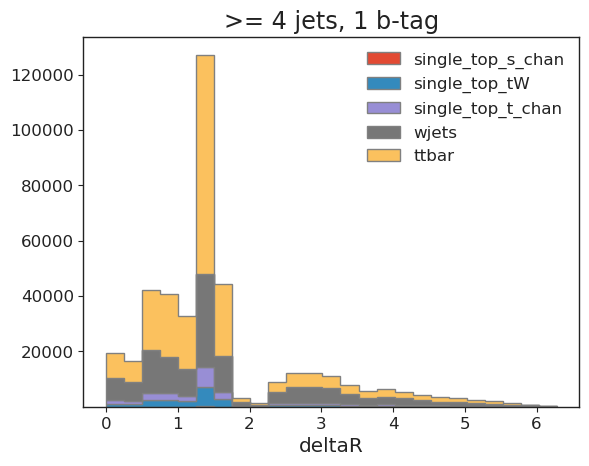

In [25]:
utils.set_style()

all_histograms[120j::hist.rebin(2), :, "4j1b", :, "nominal"].stack("process")[::-1].project("deltaR").plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, 1 b-tag")
plt.xlabel("deltaR");

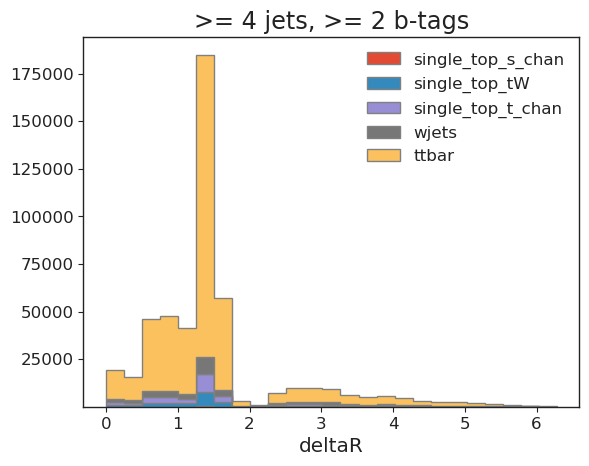

In [26]:
all_histograms[:, :, "4j2b", :, "nominal"].stack("process")[::-1].project("deltaR").plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags")
plt.xlabel("deltaR");